We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('sales.csv')

# 1.Data Analysis Phase

In [2]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df.shape

(3197, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2216 non-null   object
 1   price          3186 non-null   object
 2   weight         3193 non-null   object
 3   purchase_date  3196 non-null   object
 4   product_type   3196 non-null   object
 5   product_level  3196 non-null   object
 6   maker          2373 non-null   object
 7   ingredient     2941 non-null   object
 8   height         3197 non-null   object
 9   width          3193 non-null   object
 10  depth          3193 non-null   object
dtypes: object(11)
memory usage: 274.9+ KB


In [5]:
df.dropna(subset=['price'], inplace=True)

## Since the target 'price' is numerical values, then use Linear regression or Tree-based models.

In [6]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [7]:
train_raw.isnull().sum()

cost             835
price              0
weight             1
purchase_date      0
product_type       0
product_level      0
maker            752
ingredient       219
height             0
width              1
depth              1
year               0
dtype: int64

In [8]:
class ob2num(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        df['price'] = X.price.map(self.price2num)
        return df

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str: 
            x = x.strip(' Kg').replace(' Ton ', '.')
            return float(x)
        else:
            return x
    
    def height2num(self, x):
        if type(x) == str: 
            x = x.strip(' meters')
            return float(x)
        else:
            return x
    
    def width2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def depth2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
    
    def price2num(self, x):
        if type(x) == str:
            x = x.strip('$')
            x = x.replace(',', '')
        return float(x)

In [9]:
on = ob2num()

In [10]:
train = on.fit(train_raw)

In [11]:
train

,cost,weight,height,width,depth,price
0,333000.0,3.90,2.76,97.0,26.0,300492.0
1,NaN,3.30,2.67,98.0,26.0,430570.0
2,270000.0,3.40,3.00,93.0,24.0,213070.0
3,97000.0,2.97,2.47,101.0,26.0,122659.0
4,59000.0,2.93,2.71,96.0,25.0,60320.0
...,...,...,...,...,...,...
2752,254000.0,3.40,2.02,113.0,30.0,255179.0
2753,91000.0,2.89,2.52,99.0,26.0,144631.0
2754,NaN,2.83,2.15,106.0,28.0,40384.0
2755,44000.0,2.95,2.52,100.0,26.0,55931.0


In [12]:
numerical_features = [feature for feature in train.columns if train[feature].dtype != 'O' and feature not in ['price']]

In [13]:
numerical_features

['cost', 'weight', 'height', 'width', 'depth']

In [14]:
categorical_features = [feature for feature in train_raw.columns if feature not in train and feature not in ['purchase_date']+['year']+['price']]

In [15]:
categorical_features

['product_type', 'product_level', 'maker', 'ingredient']

In [16]:
discrete_feature=[feature for feature in numerical_features if len(train[feature].unique())<25]

In [17]:
discrete_feature

['depth']

In [18]:
continuous_feature =[feature for feature in numerical_features if feature not in discrete_feature]

In [19]:
continuous_feature

['cost', 'weight', 'height', 'width']

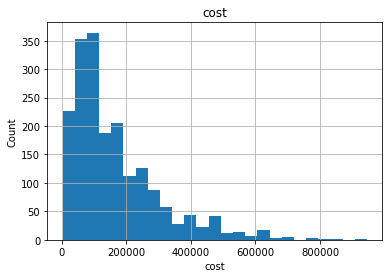

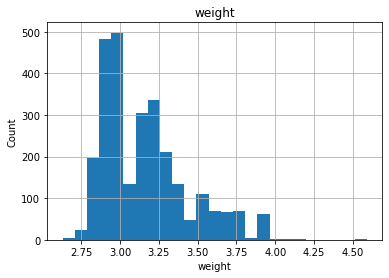

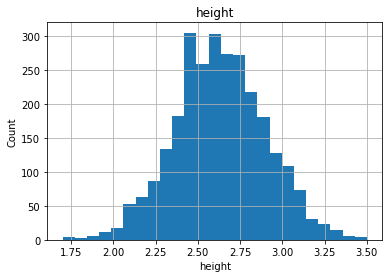

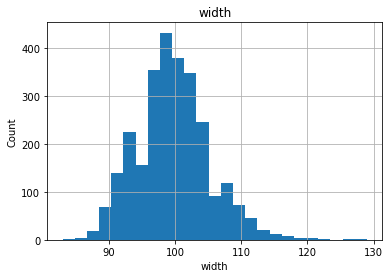

In [20]:
# analyse the continuous values by creating histograms to understand the distribution
for feature in continuous_feature:
    train[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

### 'cost' is skewed: using logarithmic transformation

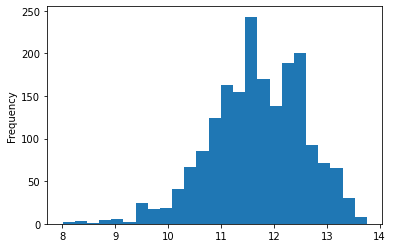

In [21]:
train.cost.map(np.log).plot(kind='hist', bins=25)

# Should a new feature which is log(cost) be create????????

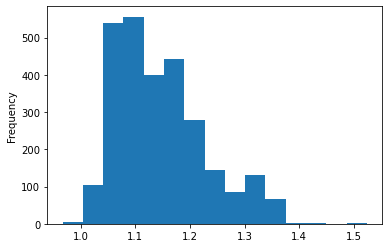

In [22]:
train.weight.map(np.log).plot(kind = 'hist', bins = 15)

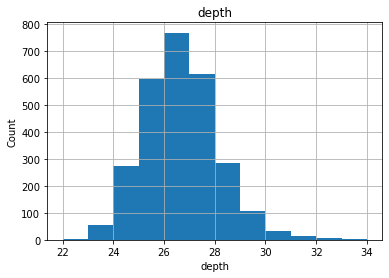

In [23]:
for feature in discrete_feature:
    train[feature].hist(bins=12)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [24]:
class DT_Transformer(object):
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X.purchase_date).dt.year
        df['month'] = pd.to_datetime(X.purchase_date).dt.month
        df['day'] = pd.to_datetime(X.purchase_date).dt.day
        return df
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [25]:
dt = DT_Transformer()

In [26]:
train_date = dt.fit_transform(train_raw)

In [27]:
train_date

,year,month,day
0,2008,12,19
1,1997,9,10
2,2001,9,5
3,2000,1,12
4,2011,8,19
...,...,...,...
2752,2012,4,20
2753,2002,7,12
2754,2007,5,25
2755,2002,4,12


In [28]:
train = train.join(train_date) 

In [29]:
train

,cost,weight,height,width,depth,price,year,month,day
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19
1,NaN,3.30,2.67,98.0,26.0,430570.0,1997,9,10
2,270000.0,3.40,3.00,93.0,24.0,213070.0,2001,9,5
3,97000.0,2.97,2.47,101.0,26.0,122659.0,2000,1,12
4,59000.0,2.93,2.71,96.0,25.0,60320.0,2011,8,19
...,...,...,...,...,...,...,...,...,...
2752,254000.0,3.40,2.02,113.0,30.0,255179.0,2012,4,20
2753,91000.0,2.89,2.52,99.0,26.0,144631.0,2002,7,12
2754,NaN,2.83,2.15,106.0,28.0,40384.0,2007,5,25
2755,44000.0,2.95,2.52,100.0,26.0,55931.0,2002,4,12


Text(0.5, 1.0, 'price vs purchase_year')

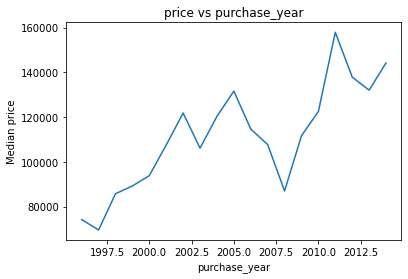

In [30]:
train.groupby('year')['price'].median().plot()
plt.xlabel('purchase_year')
plt.ylabel('Median price')
plt.title("price vs purchase_year")

Text(0.5, 1.0, 'price vs purchase_month')

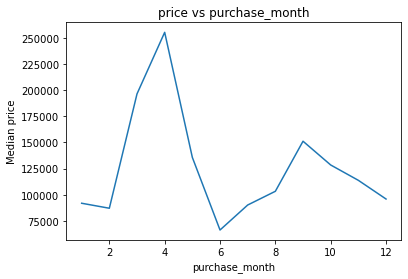

In [31]:
train.groupby('month')['price'].median().plot()
plt.xlabel('purchase_month')
plt.ylabel('Median price')
plt.title("price vs purchase_month")

Text(0.5, 1.0, 'price vs purchase_day')

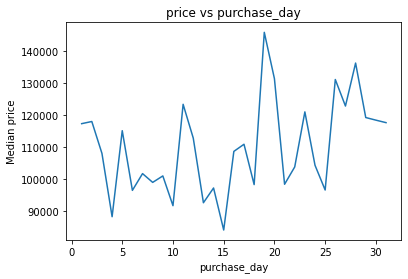

In [32]:
train.groupby('day')['price'].median().plot()
plt.xlabel('purchase_day')
plt.ylabel('Median price')
plt.title("price vs purchase_day")

## check Outliers

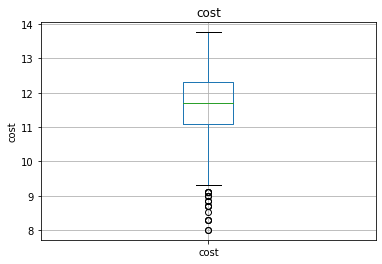

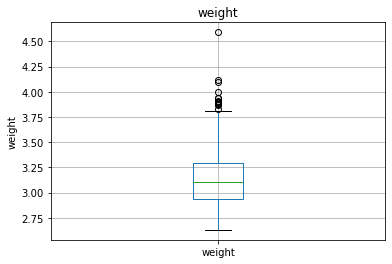

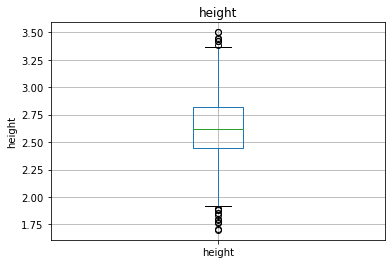

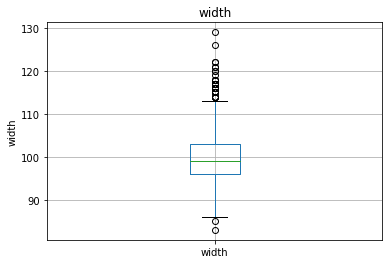

In [33]:
for feature in continuous_feature:
    data=train.copy()
    if 0 in data[feature].unique():
        pass
    if feature == 'cost':
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()  
    else:
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [34]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(train_raw[feature].unique())))

The feature is product_type and number of categories are 64
The feature is product_level and number of categories are 5
The feature is maker and number of categories are 772
The feature is ingredient and number of categories are 2435


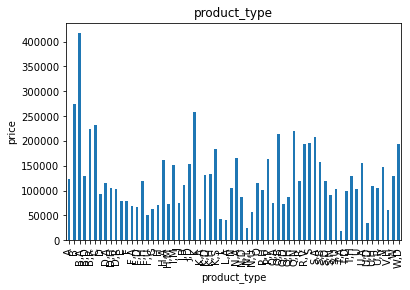

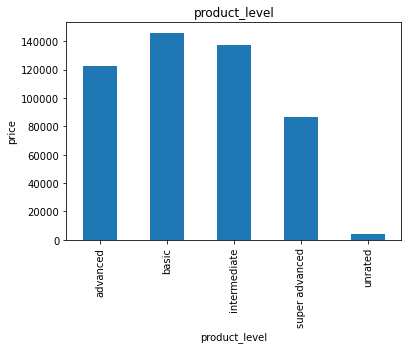

In [35]:
## Find out the relationship between categorical variable and dependent feature price
for feature in categorical_features:
    data=train_raw.copy()
    data['price'] = train['price']
    if feature not in ['ingredient','maker']:
        data.groupby(feature)['price'].median().plot.bar()
        plt.xlabel(feature)
        plt.ylabel('price')
        plt.title(feature)
        plt.show()

In [36]:
from pandas import Series, DataFrame

maker_split = train_raw['maker'].str.split(',').apply(Series, 1).stack()
maker_split.index = maker_split.index.droplevel(-1)
maker_split.name = 'maker'

In [37]:
maker_ana = train[['price']].join(maker_split)

In [38]:
maker_ana.maker

0       M14122
1          NaN
2          NaN
3          NaN
4       M14124
         ...  
2752    M14261
2753    M14904
2754    M14578
2755    M14341
2756       NaN
Name: maker, Length: 2851, dtype: object

# 2. Feature Engineering

In [39]:
## check for numerical variables the contains missing values
numerical_with_nan=[feature for feature in train.columns if train[feature].isnull().sum()>0 and feature not in ['price']]

## print the numerical nan variables and percentage of missing values

for feature in numerical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(train[feature].isnull().mean(),4)))

cost: 0.3029% missing value
weight: 0.0004% missing value
height: 0.0004% missing value
width: 0.0004% missing value
depth: 0.0004% missing value


In [40]:
## Replacing the numerical Missing Values

for feature in numerical_with_nan:
    ## replace by using median since there are outliers
    median_value=train[feature].median()
    train[feature].fillna(median_value,inplace=True)
    
train[numerical_with_nan].isnull().sum()   

cost      0
weight    0
height    0
width     0
depth     0
dtype: int64

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cost    2757 non-null   float64
 1   weight  2757 non-null   float64
 2   height  2757 non-null   float64
 3   width   2757 non-null   float64
 4   depth   2757 non-null   float64
 5   price   2757 non-null   float64
 6   year    2757 non-null   int64  
 7   month   2757 non-null   int64  
 8   day     2757 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 194.0 KB


### Categorical features

In [42]:
## check for categorical variables the contains missing values
categorical_with_nan=[feature for feature in train_raw.columns if train_raw[feature].isnull().sum()>0 and feature not in train.columns]

## print the categorical nan variables and percentage of missing values

for feature in categorical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(train_raw[feature].isnull().mean(),4)))

maker: 0.2728% missing value
ingredient: 0.0794% missing value


In [43]:
train_raw['maker'].mode()
train_raw['ingredient'].mode()

0    IN732638
dtype: object

### 'maker'

In [44]:
train = train.join(train_raw[['product_type','product_level','maker','ingredient']]) 

In [45]:
maker = train.maker.value_counts().to_dict()

In [46]:
maker

{'M14346': 15,
 'M14196': 14,
 'M14163': 13,
 'M14170': 13,
 'M14313': 12,
 'M14427': 12,
 'M14164': 11,
 'M14565': 10,
 'M14505': 10,
 'M14216': 10,
 'M14218': 9,
 'M14457': 9,
 'M14184': 9,
 'M14128': 9,
 'M14743': 9,
 'M14319': 9,
 'M14149': 8,
 'M14188': 8,
 'M14209': 8,
 'M14464': 8,
 'M14206': 8,
 'M14273': 8,
 'M14205': 8,
 'M14504': 8,
 'M14441': 8,
 'M14126': 8,
 'M14312': 8,
 'M14253': 8,
 'M14283': 8,
 'M14664': 8,
 'M14286': 8,
 'M14136': 7,
 'M14551': 7,
 'M14315': 7,
 'M14545': 7,
 'M14159': 7,
 'M14211': 7,
 'M14298': 7,
 'M14166': 7,
 'M14361': 7,
 'M14538': 7,
 'M14582': 7,
 'M14241': 7,
 'M14245': 7,
 'M14156': 7,
 'M14419': 7,
 'M14478': 7,
 'M14317': 7,
 'M14122': 7,
 'M14291': 7,
 'M14225': 6,
 'M14150': 6,
 'M14257': 6,
 'M14367': 6,
 'M14322': 6,
 'M14325': 6,
 'M14362': 6,
 'M14141': 6,
 'M14536': 6,
 'M14410': 6,
 'M14232': 6,
 'M14289': 6,
 'M14324': 6,
 'M14172': 6,
 'M14455': 6,
 'M14295': 6,
 'M14287': 6,
 'M14261': 6,
 'M14143': 6,
 'M14340': 6,
 'M14145':

In [47]:
first_10 = list(maker)[:10]
print (first_10)

['M14346', 'M14196', 'M14163', 'M14170', 'M14313', 'M14427', 'M14164', 'M14565', 'M14505', 'M14216']


In [48]:
# break up 'maker' and 'ingredient' to get the mode value to fill in nan values
def breakup(x):
    if type(x) == str:
        parts = x.split(',')
        return parts

In [49]:
dict_maker = {}
for maker in train[train.maker.notnull()].maker.map(breakup):
    for m in maker:
        if m in dict_maker.keys():
            dict_maker[m] += 1
        else:
            dict_maker[m] = 1

In [50]:
dict_maker = sorted(dict_maker.items(), key = lambda x: x[1], reverse = True)

In [51]:
first_ten = list(dict_maker)[:10]
print (first_ten)

[('M14346', 15), ('M14196', 14), ('M14163', 13), ('M14170', 13), ('M14565', 13), ('M14313', 12), ('M14427', 12), ('M14164', 11), ('M14216', 10), ('M14505', 10)]


In [52]:
def Extract(lst): 
    return [item[0] for item in lst] 
      
print(Extract(first_ten)) 

['M14346', 'M14196', 'M14163', 'M14170', 'M14565', 'M14313', 'M14427', 'M14164', 'M14216', 'M14505']


In [53]:
list(set(Extract(first_ten)) & set(first_10))

['M14505',
 'M14170',
 'M14164',
 'M14565',
 'M14216',
 'M14427',
 'M14313',
 'M14346',
 'M14163',
 'M14196']

In [54]:
print (set(Extract(first_ten)) == set(first_10))

True


In [55]:
train[['maker']].head(20)

,maker
0,M14122
1,NaN
2,NaN
3,NaN
4,M14124
5,M14125
6,M14126
7,NaN
8,M14127
9,M14129


### replace the missing values with the maximum number of the list 'first_ten'

### since the top 10 most frequent values are the same with splitting the cells, no need to split the cell to different rows

In [56]:
train['maker'].fillna(first_ten[0][0],inplace=True)

In [57]:
train['maker'].isnull().sum()

0

In [58]:
def rar(x):
    if type(x)== str:
        if x not in first_10:
            x = 'rar'
        else:
            pass
    return x

### 'ingredient'

In [59]:
ingredient = train_raw.ingredient.value_counts().to_dict()

In [60]:
ingredient

{'IN732638': 8,
 'IN732362': 6,
 'IN732502': 4,
 'IN732859': 4,
 'IN732832': 4,
 'IN732835': 4,
 'IN732200': 4,
 'IN732993': 4,
 'IN732094': 3,
 'IN733022': 3,
 'IN732126': 3,
 'IN732789': 3,
 'IN732254': 3,
 'IN732275': 3,
 'IN732231': 3,
 'IN732064': 3,
 'IN733224,IN732329': 2,
 'IN732484': 2,
 'IN732275,IN732231,IN733129,IN732903': 2,
 'IN732788': 2,
 'IN733153,IN733155,IN732348,IN733154': 2,
 'IN732347': 2,
 'IN732591': 2,
 'IN732446': 2,
 'IN732427': 2,
 'IN732571': 2,
 'IN732684': 2,
 'IN732559': 2,
 'IN732217,IN732219': 2,
 'IN732657,IN732658': 2,
 'IN732710': 2,
 'IN733469,IN732581,IN732589': 2,
 'IN732872': 2,
 'IN732410': 2,
 'IN732466': 2,
 'IN732701': 2,
 'IN732617': 2,
 'IN732587': 2,
 'IN732728,IN732532,IN733627': 2,
 'IN732322': 2,
 'IN732101': 2,
 'IN732660': 2,
 'IN732566': 2,
 'IN733593,IN732277,IN732595,IN732642': 2,
 'IN732231,IN732093,IN732645,IN733055,IN732632,IN733056,IN733057,IN732375': 2,
 'IN732385': 2,
 'IN732692': 2,
 'IN732218': 2,
 'IN733094': 2,
 'IN73239

In [61]:
ing_first_10 = list(ingredient)[:10]
print (ing_first_10)

['IN732638', 'IN732362', 'IN732502', 'IN732859', 'IN732832', 'IN732835', 'IN732200', 'IN732993', 'IN732094', 'IN733022']


In [62]:
dict_ingredient = {}
for ingredient in train[train.ingredient.notnull()].ingredient.map(breakup):
    for i in ingredient:
        if i in dict_ingredient.keys():
            dict_ingredient[i] += 1
        else:
            dict_ingredient[i] = 1

In [63]:
dict_ingredient = sorted(dict_ingredient.items(), key = lambda x: x[1], reverse = True)

In [64]:
ing_first_ten = list(dict_ingredient)[:10]
print (ing_first_ten)

[('IN732658', 57), ('IN732094', 45), ('IN732489', 41), ('IN732074', 40), ('IN732583', 36), ('IN732097', 35), ('IN732231', 35), ('IN732503', 33), ('IN732505', 33), ('IN732217', 30)]


In [65]:
train['ingredient'].fillna(ing_first_ten[0][0],inplace=True)

In [66]:
train['ingredient'].isnull().sum()

0

In [67]:
print(Extract(ing_first_ten)) 

['IN732658', 'IN732094', 'IN732489', 'IN732074', 'IN732583', 'IN732097', 'IN732231', 'IN732503', 'IN732505', 'IN732217']


In [68]:
list(set(Extract(ing_first_ten)) & set(ing_first_10))

['IN732094']

In [69]:
from pandas import Series, DataFrame

ing_split = train['ingredient'].str.split(',').apply(Series, 1).stack()
ing_split.index = ing_split.index.droplevel(-1)
ing_split.name = 'ingredient'
del train['ingredient']

In [70]:
ing_split

0       IN732052
0       IN732053
1       IN732054
1       IN732055
1       IN732056
          ...   
2754    IN733785
2754    IN732069
2754    IN732797
2755    IN732587
2756    IN732658
Name: ingredient, Length: 11835, dtype: object

### 'product_type'

In [71]:
product_type = train.product_type.value_counts().to_dict()

In [72]:
product_type

{'D': 417,
 'N': 172,
 'C': 170,
 'D,R': 160,
 'H': 149,
 'U': 147,
 'A': 113,
 'J,D': 94,
 'D,H': 77,
 'D,A': 75,
 'J,B': 65,
 'R': 57,
 'U,H': 54,
 'U,A': 53,
 'T,H': 47,
 'F,D': 42,
 'K': 42,
 'P,H': 41,
 'F,H': 40,
 'S,A': 40,
 'B,A': 39,
 'Q,H': 39,
 'T,D': 36,
 'H,A': 34,
 'S,N': 30,
 'N,A': 28,
 'K,D': 27,
 'J': 27,
 'Q,B': 26,
 'N,U': 26,
 'S,U': 25,
 'N,D': 23,
 'S,B': 22,
 'F,U': 21,
 'F,A': 20,
 'B': 20,
 'V': 20,
 'P,P': 19,
 'G': 17,
 'S,D': 16,
 'K,H': 16,
 'F': 15,
 'S': 13,
 'V,H': 13,
 'U,R': 13,
 'W': 12,
 'H,M': 10,
 'E': 10,
 'Q,A': 10,
 'K,S': 9,
 'B,D': 8,
 'Q,N': 8,
 'L,A': 7,
 'Q,D': 7,
 'U,D': 7,
 'L': 5,
 'I,M': 5,
 'K,A': 5,
 'T,A': 3,
 'W,D': 3,
 'N,L': 3,
 'O': 2,
 'R,V': 2,
 'B,R': 1}

In [73]:
pt_first_10 = list(product_type)[:10]
print (pt_first_10)

['D', 'N', 'C', 'D,R', 'H', 'U', 'A', 'J,D', 'D,H', 'D,A']


In [74]:
dict_pt = {}
for pt in train[train.product_type.notnull()].product_type.map(breakup):
    for i in pt:
        if i in dict_pt.keys():
            dict_pt[i] += 1
        else:
            dict_pt[i] = 1

In [75]:
dict_pt = sorted(dict_pt.items(), key = lambda x: x[1], reverse = True)

In [76]:
pt_first_ten = list(dict_pt)[:10]
print (pt_first_ten)

[('D', 992), ('H', 520), ('A', 427), ('U', 346), ('N', 290), ('R', 233), ('J', 186), ('B', 181), ('C', 170), ('S', 155)]


In [77]:
list(set(Extract(pt_first_ten)) & set(pt_first_10))

['D', 'U', 'N', 'C', 'H', 'A']

In [78]:
pt_split = train['product_type'].str.split(',').apply(Series, 1).stack()
pt_split.index = pt_split.index.droplevel(-1)
pt_split.name = 'product_type'
del train['product_type']

In [79]:
pt_split

0       Q
0       B
1       J
1       D
2       J
       ..
2753    D
2754    J
2754    B
2755    R
2756    N
Name: product_type, Length: 4106, dtype: object

In [80]:
train_split = train.join(pd.DataFrame(ing_split).join(pt_split))

### using one_hot_encoding for data transforming

In [81]:
def one_hot_encoding_top_x(df, variable, top_x_labels):
    # function to create the dummy variables for the most frequent labels
    # we can vary the number of most frequent labels that we encode
    
    for label in top_x_labels:
        df[variable+'_'+label] = np.where(df[variable]==label, 1, 0)

In [82]:
one_hot_encoding_top_x(train_split, 'maker', first_10)

In [83]:
one_hot_encoding_top_x(train_split, 'ingredient', Extract(ing_first_ten))

In [84]:
one_hot_encoding_top_x(train_split, 'product_type', Extract(pt_first_ten))

In [85]:
train_split[['maker']].head(20)

,maker
0,M14122
0,M14122
0,M14122
0,M14122
1,M14346
1,M14346
1,M14346
1,M14346
1,M14346
1,M14346


### use label encoding

### 'product_level'

#### use ordinal label

In [86]:
dic = {'unrated':0, 'basic':1, 'intermediate':2, 'advanced':3, 'super advanced':4}
train_split['product_level'] = train_split.product_level.map(dic)

In [87]:
train_split

,cost,weight,height,width,depth,price,year,month,day,product_level,...,product_type_D,product_type_H,product_type_A,product_type_U,product_type_N,product_type_R,product_type_J,product_type_B,product_type_C,product_type_S
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19,3,...,0,0,0,0,0,0,0,0,0,0
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19,3,...,0,0,0,0,0,0,0,1,0,0
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19,3,...,0,0,0,0,0,0,0,0,0,0
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19,3,...,0,0,0,0,0,0,0,1,0,0
1,122000.0,3.30,2.67,98.0,26.0,430570.0,1997,9,10,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,122000.0,2.83,2.15,106.0,28.0,40384.0,2007,5,25,2,...,0,0,0,0,0,0,0,1,0,0
2754,122000.0,2.83,2.15,106.0,28.0,40384.0,2007,5,25,2,...,0,0,0,0,0,0,1,0,0,0
2754,122000.0,2.83,2.15,106.0,28.0,40384.0,2007,5,25,2,...,0,0,0,0,0,0,0,1,0,0
2755,44000.0,2.95,2.52,100.0,26.0,55931.0,2002,4,12,3,...,0,0,0,0,0,1,0,0,0,0


# 3. Feature selection

## 3.1 Lasso

In [88]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [89]:
y_train=train_split[['price']]

In [90]:
X_train=train_split.drop(['price', 'ingredient','maker','product_type'],axis=1)

In [91]:
### Apply Feature Selection
# first, I specify the Lasso Regression model, and I
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then I use the selectFromModel object from sklearn, which
# will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [92]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

## 3.2 Correlation

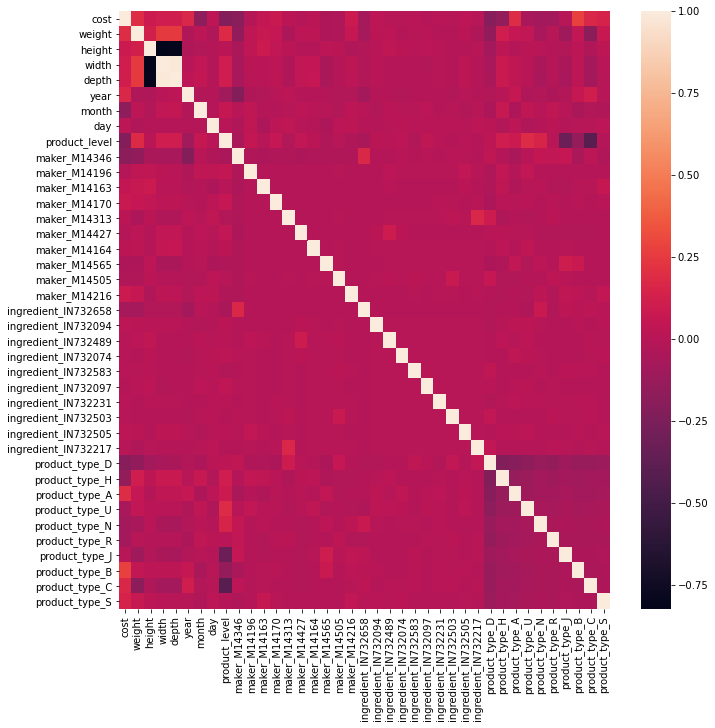

In [93]:
import seaborn as sns
#Using Pearson Correlation
corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

In [94]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [95]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

1

In [96]:
corr_features

{'depth'}

In [97]:
X_train = X_train.drop(corr_features,axis=1)

In [98]:
X_train

,cost,weight,height,width,year,month,day,product_level,maker_M14346,maker_M14196,...,product_type_D,product_type_H,product_type_A,product_type_U,product_type_N,product_type_R,product_type_J,product_type_B,product_type_C,product_type_S
0,333000.0,3.90,2.76,97.0,2008,12,19,3,0,0,...,0,0,0,0,0,0,0,0,0,0
0,333000.0,3.90,2.76,97.0,2008,12,19,3,0,0,...,0,0,0,0,0,0,0,1,0,0
0,333000.0,3.90,2.76,97.0,2008,12,19,3,0,0,...,0,0,0,0,0,0,0,0,0,0
0,333000.0,3.90,2.76,97.0,2008,12,19,3,0,0,...,0,0,0,0,0,0,0,1,0,0
1,122000.0,3.30,2.67,98.0,1997,9,10,1,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,122000.0,2.83,2.15,106.0,2007,5,25,2,0,0,...,0,0,0,0,0,0,0,1,0,0
2754,122000.0,2.83,2.15,106.0,2007,5,25,2,0,0,...,0,0,0,0,0,0,1,0,0,0
2754,122000.0,2.83,2.15,106.0,2007,5,25,2,0,0,...,0,0,0,0,0,0,0,1,0,0
2755,44000.0,2.95,2.52,100.0,2002,4,12,3,0,0,...,0,0,0,0,0,1,0,0,0,0


### will do scaling in model building 

## transform test dataset

In [99]:
test = on.fit(test_raw)

In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cost    289 non-null    float64
 1   weight  427 non-null    float64
 2   height  427 non-null    float64
 3   width   427 non-null    float64
 4   depth   427 non-null    float64
 5   price   429 non-null    float64
dtypes: float64(6)
memory usage: 20.2 KB


In [101]:
test = test.drop(['depth'], axis=1)

In [102]:
test

,cost,weight,height,width,price
0,NaN,3.50,2.50,102.0,229174.0
1,160000.0,3.44,2.91,100.0,168762.0
2,160000.0,3.12,2.93,95.0,605022.0
3,NaN,2.98,2.14,109.0,4444.0
4,18000.0,3.21,2.58,103.0,17932.0
...,...,...,...,...,...
424,37000.0,3.90,2.84,96.0,107358.0
425,NaN,3.23,2.19,112.0,47939.0
426,562000.0,3.43,2.49,108.0,491055.0
427,NaN,3.00,2.02,112.0,93349.0


In [103]:
test_date = dt.fit_transform(test_raw)

In [104]:
test = test.join(test_date)

In [105]:
for feature in ['cost','weight','height','width']:
    median = test[feature].median()
    test[feature].fillna(median, inplace=True)

test[feature].isnull().sum() 

0

In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cost    429 non-null    float64
 1   weight  429 non-null    float64
 2   height  429 non-null    float64
 3   width   429 non-null    float64
 4   price   429 non-null    float64
 5   year    429 non-null    int64  
 6   month   429 non-null    int64  
 7   day     429 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 26.9 KB


In [107]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           289 non-null    object
 1   price          429 non-null    object
 2   weight         427 non-null    object
 3   purchase_date  429 non-null    object
 4   product_type   429 non-null    object
 5   product_level  429 non-null    object
 6   maker          360 non-null    object
 7   ingredient     394 non-null    object
 8   height         429 non-null    object
 9   width          427 non-null    object
 10  depth          427 non-null    object
 11  year           429 non-null    int64 
dtypes: int64(1), object(11)
memory usage: 40.3+ KB


In [108]:
test = test.join(test_raw[['product_type','product_level','maker','ingredient']]) 

In [109]:
test['maker'].fillna(first_ten[0][0],inplace=True)

In [110]:
test['ingredient'].fillna(ing_first_ten[0][0],inplace=True)

In [111]:
ing_splitt = test['ingredient'].str.split(',').apply(Series, 1).stack()
ing_splitt.index = ing_splitt.index.droplevel(-1)
ing_splitt.name = 'ingredient'
del test['ingredient']

In [112]:
pt_splitt = test['product_type'].str.split(',').apply(Series, 1).stack()
pt_splitt.index = pt_splitt.index.droplevel(-1)
pt_splitt.name = 'product_type'
del test['product_type']

In [113]:
test_split = test.join(pd.DataFrame(ing_splitt).join(pt_splitt))

In [114]:
test_split

,cost,weight,height,width,price,year,month,day,product_level,maker,ingredient,product_type
0,122000.0,3.50,2.50,102.0,229174.0,2016,12,23,advanced,M14123,IN732061,U
0,122000.0,3.50,2.50,102.0,229174.0,2016,12,23,advanced,M14123,IN732062,U
0,122000.0,3.50,2.50,102.0,229174.0,2016,12,23,advanced,M14123,IN732063,U
1,160000.0,3.44,2.91,100.0,168762.0,2016,10,28,super advanced,M14128,IN732088,H
1,160000.0,3.44,2.91,100.0,168762.0,2016,10,28,super advanced,M14128,IN732089,H
...,...,...,...,...,...,...,...,...,...,...,...,...
428,122000.0,3.80,2.84,96.0,1074844.0,2016,12,16,intermediate,"M14883,M15011",IN734088,C
428,122000.0,3.80,2.84,96.0,1074844.0,2016,12,16,intermediate,"M14883,M15011",IN733474,C
428,122000.0,3.80,2.84,96.0,1074844.0,2016,12,16,intermediate,"M14883,M15011",IN732868,C
428,122000.0,3.80,2.84,96.0,1074844.0,2016,12,16,intermediate,"M14883,M15011",IN732266,C


In [115]:
one_hot_encoding_top_x(test_split, 'maker', first_10)

In [116]:
one_hot_encoding_top_x(test_split, 'ingredient', Extract(ing_first_ten))

In [117]:
one_hot_encoding_top_x(test_split, 'product_type', Extract(pt_first_ten))

In [118]:
test_split['product_level'] = test_split.product_level.map(dic)

In [119]:
X_test = test_split.drop(['price', 'ingredient','maker','product_type'],axis=1)

In [120]:
X_test.columns

Index(['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level', 'maker_M14346', 'maker_M14196', 'maker_M14163',
       'maker_M14170', 'maker_M14313', 'maker_M14427', 'maker_M14164',
       'maker_M14565', 'maker_M14505', 'maker_M14216', 'ingredient_IN732658',
       'ingredient_IN732094', 'ingredient_IN732489', 'ingredient_IN732074',
       'ingredient_IN732583', 'ingredient_IN732097', 'ingredient_IN732231',
       'ingredient_IN732503', 'ingredient_IN732505', 'ingredient_IN732217',
       'product_type_D', 'product_type_H', 'product_type_A', 'product_type_U',
       'product_type_N', 'product_type_R', 'product_type_J', 'product_type_B',
       'product_type_C', 'product_type_S'],
      dtype='object')

In [121]:
y_test = test_split[['price']]

# 4. Model Building

In [122]:
# Importing Classifier Modules, as discussed at the beginning, only LR & tree-based models will be considered

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [123]:
from xgboost.sklearn import XGBRegressor
conda install -c conda-forge xgboost

SyntaxError: invalid syntax (<ipython-input-123-937aa1fe9551>, line 2)

## 4.1 Regularized Linear Regression

In [124]:
steps1 = [('rescale', MinMaxScaler()),
         ('pca', PCA(n_components = 2)),
         ('poly', PolynomialFeatures()),
         ('lasso', Lasso(max_iter = 100))]
model1 = Pipeline(steps1)
model1 = model1.fit(X_train, y_train)

In [125]:
parameters1 = {'lasso__alpha': np.arange(0.1,1,0.1), 
              'poly__degree': range(2,8)}

In [126]:
scorer1 = make_scorer(mean_squared_error, greater_is_better = False)

In [127]:
model1 = GridSearchCV(model1, parameters1, cv=5, scoring = scorer1)

In [128]:
model1.fit(X_train, y_train)

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414613874390591.3, tolerance: 105407788981.1624
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408348205753341.06, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395635449607784.94, tolerance: 97568934394.92003
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374584047879841.8, tolerance: 91832433309.57408
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410386731489240.7, tolerance: 98772680113.59616
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412415856029032.1, tolerance: 105407788981.1624
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405999343834200.8, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392967151904473.6, tolerance: 97568934394.92003
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371715828566046.6, tolerance: 91832433309.57408
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 402722492280979.06, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392277774749755.1, tolerance: 97568934394.92003
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370634603839266.2, tolerance: 91832433309.57408
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406832510869316.2, tolerance: 98772680113.59616
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409763261320674.8, tolerance: 105407788981.1624
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401759298365337.6, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391336019853316.25, tolerance: 97568934394.92003
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369711485655916.06, tolerance: 91832433309.57408
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406175743181655.1, tolerance: 98772680113.59616
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407038063613616.44, tolerance: 105407788981.1624
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398430695384993.9, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390375528396811.7, tolerance: 97568934394.92003
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404255709189879.9, tolerance: 98772680113.59616
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407526431757745.8, tolerance: 105407788981.1624
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 402212978291733.75, tolerance: 98964245712.08815
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', MinMaxScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('poly', PolynomialFeatures()),
                                       ('lasso', Lasso(max_iter=100))]),
             param_grid={'lasso__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'poly__degree': range(2, 8)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [129]:
model1.best_params_

{'lasso__alpha': 0.8, 'poly__degree': 7}

In [130]:
y_train_pred1 = model1.predict(X_train)

In [131]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred1)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred1)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred1)))

train MAE: 1.62e+05
train MSE: 5.69e+10
train R2: 0.190


In [132]:
y_test_pred1 = model1.predict(X_test)

In [133]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred1)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred1)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred1)))

train MAE: 2.38e+05
train MSE: 1.39e+11
train R2: 0.281


## 4.2 Decision Tree

In [134]:
steps2 = [('rescale', MinMaxScaler()),
         ('dt', DecisionTreeRegressor(random_state=0))]
model2 = Pipeline(steps2)
model2 = model2.fit(X_train, y_train)

In [135]:
parameters2 = {'dt__max_depth':range(1,11,2),
               'dt__min_samples_leaf':range(20,200,20),
               'dt__min_samples_split':range(2,7)}

In [136]:
scorer2 = make_scorer(mean_squared_error, greater_is_better = False)

In [137]:
model2gs = GridSearchCV(model2, parameters2, cv=5, scoring = scorer2)

In [138]:
model2gs = model2gs.fit(X_train, y_train)

In [139]:
model2gs.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 140, 'dt__min_samples_split': 2}

In [140]:
y_train_pred2 = model2gs.predict(X_train)

In [141]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred2)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred2)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred2)))

train MAE: 1.30e+05
train MSE: 3.92e+10
train R2: 0.442


In [142]:
y_test_pred2 = model2gs.predict(X_test)

In [143]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred2)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred2)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred2)))

train MAE: 1.75e+05
train MSE: 1.20e+11
train R2: 0.378


In [144]:
importancedt = model2.steps[1][1].feature_importances_
importancedt

array([4.46813708e-01, 1.15525837e-01, 5.89474681e-02, 4.42767549e-02,
       7.93745585e-02, 3.73653223e-02, 1.48346557e-01, 2.62834566e-02,
       8.64182266e-03, 4.23862377e-08, 1.04228761e-03, 1.13391265e-06,
       4.15592015e-08, 4.03282922e-03, 1.79553409e-03, 0.00000000e+00,
       1.04971499e-04, 9.55837970e-05, 9.00744454e-04, 4.64094893e-07,
       1.57350027e-04, 0.00000000e+00, 1.01848641e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.21453091e-03, 5.63603997e-04, 5.26650242e-04, 3.28975053e-04,
       1.63177748e-03, 8.50236059e-03, 1.33701014e-03, 1.47941949e-03,
       7.72286927e-03, 8.84487136e-04])

([<matplotlib.axis.XTick at 0x18c32f0b5e0>,
 [Text(0, 0, 'cost'),
  Text(0, 0, 'weight'),
  Text(0, 0, 'height'),
  Text(0, 0, 'width'),
  Text(0, 0, 'year'),
  Text(0, 0, 'month'),
  Text(0, 0, 'day'),
  Text(0, 0, 'product_level'),
  Text(0, 0, 'maker_M14346'),
  Text(0, 0, 'maker_M14196'),
  Text(0, 0, 'maker_M14170'),
  Text(0, 0, 'maker_M14163'),
  Text(0, 0, 'maker_M14313'),
  Text(0, 0, 'maker_M14427'),
  Text(0, 0, 'maker_M14164'),
  Text(0, 0, 'maker_M14216'),
  Text(0, 0, 'maker_M14565'),
  Text(0, 0, 'maker_M14505'),
  Text(0, 0, 'ingredient_IN732658'),
  Text(0, 0, 'ingredient_IN732094'),
  Text(0, 0, 'ingredient_IN732489'),
  Text(0, 0, 'ingredient_IN732074'),
  Text(0, 0, 'ingredient_IN732583'),
  Text(0, 0, 'ingredient_IN732097'),
  Text(0, 0, 'ingredient_IN732231'),
  Text(0, 0, 'ingredient_IN732503'),
  Text(0, 0, 'ingredient_IN732505'),
  Text(0, 0, 'ingredient_IN732217'),
  Text(0, 0, 'product_type_D'),
  Text(0, 0, 'product_type_H'),
  Text(0, 0, 'product_type_A'),


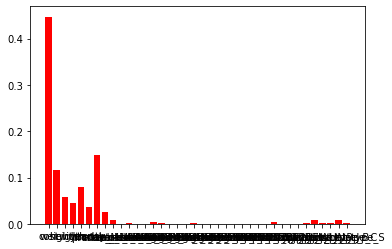

In [145]:
plt.bar(range(len(importancedt)), importancedt, color="r", align = "center")
plt.xticks(range(len(importancedt)), ['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level', 'maker_M14346', 'maker_M14196', 'maker_M14170',
       'maker_M14163', 'maker_M14313', 'maker_M14427', 'maker_M14164',
       'maker_M14216', 'maker_M14565', 'maker_M14505', 'ingredient_IN732658',
       'ingredient_IN732094', 'ingredient_IN732489', 'ingredient_IN732074',
       'ingredient_IN732583', 'ingredient_IN732097', 'ingredient_IN732231',
       'ingredient_IN732503', 'ingredient_IN732505', 'ingredient_IN732217',
       'product_type_D', 'product_type_H', 'product_type_A', 'product_type_U',
       'product_type_N', 'product_type_R', 'product_type_J', 'product_type_B',
       'product_type_C', 'product_type_S'])

### It looks like 'maker', 'ingredient' and 'product_type' do not have too much impact on predicting the 'price' model, try drop these features

In [146]:
train

,cost,weight,height,width,depth,price,year,month,day,product_level,maker
0,333000.0,3.90,2.76,97.0,26.0,300492.0,2008,12,19,advanced,M14122
1,122000.0,3.30,2.67,98.0,26.0,430570.0,1997,9,10,basic,M14346
2,270000.0,3.40,3.00,93.0,24.0,213070.0,2001,9,5,basic,M14346
3,97000.0,2.97,2.47,101.0,26.0,122659.0,2000,1,12,advanced,M14346
4,59000.0,2.93,2.71,96.0,25.0,60320.0,2011,8,19,super advanced,M14124
...,...,...,...,...,...,...,...,...,...,...,...
2752,254000.0,3.40,2.02,113.0,30.0,255179.0,2012,4,20,intermediate,M14261
2753,91000.0,2.89,2.52,99.0,26.0,144631.0,2002,7,12,advanced,M14904
2754,122000.0,2.83,2.15,106.0,28.0,40384.0,2007,5,25,intermediate,M14578
2755,44000.0,2.95,2.52,100.0,26.0,55931.0,2002,4,12,advanced,M14341


In [166]:
X_train = train.drop(['maker','price','depth'], axis=1)
X_train

,cost,weight,height,width,year,month,day,product_level
0,333000.0,3.90,2.76,97.0,2008,12,19,advanced
1,122000.0,3.30,2.67,98.0,1997,9,10,basic
2,270000.0,3.40,3.00,93.0,2001,9,5,basic
3,97000.0,2.97,2.47,101.0,2000,1,12,advanced
4,59000.0,2.93,2.71,96.0,2011,8,19,super advanced
...,...,...,...,...,...,...,...,...
2752,254000.0,3.40,2.02,113.0,2012,4,20,intermediate
2753,91000.0,2.89,2.52,99.0,2002,7,12,advanced
2754,122000.0,2.83,2.15,106.0,2007,5,25,intermediate
2755,44000.0,2.95,2.52,100.0,2002,4,12,advanced


In [167]:
dic = {'unrated':0, 'basic':1, 'intermediate':2, 'advanced':3, 'super advanced':4}
X_train['product_level'] = X_train.product_level.map(dic)
X_train

,cost,weight,height,width,year,month,day,product_level
0,333000.0,3.90,2.76,97.0,2008,12,19,3
1,122000.0,3.30,2.67,98.0,1997,9,10,1
2,270000.0,3.40,3.00,93.0,2001,9,5,1
3,97000.0,2.97,2.47,101.0,2000,1,12,3
4,59000.0,2.93,2.71,96.0,2011,8,19,4
...,...,...,...,...,...,...,...,...
2752,254000.0,3.40,2.02,113.0,2012,4,20,2
2753,91000.0,2.89,2.52,99.0,2002,7,12,3
2754,122000.0,2.83,2.15,106.0,2007,5,25,2
2755,44000.0,2.95,2.52,100.0,2002,4,12,3


In [168]:
y_train = train.price
y_train

0       300492.0
1       430570.0
2       213070.0
3       122659.0
4        60320.0
          ...   
2752    255179.0
2753    144631.0
2754     40384.0
2755     55931.0
2756     44370.0
Name: price, Length: 2757, dtype: float64

In [169]:
test

,cost,weight,height,width,price,year,month,day,product_level,maker
0,122000.0,3.50,2.50,102.0,229174.0,2016,12,23,advanced,M14123
1,160000.0,3.44,2.91,100.0,168762.0,2016,10,28,super advanced,M14128
2,160000.0,3.12,2.93,95.0,605022.0,2015,3,27,super advanced,M14137
3,122000.0,2.98,2.14,109.0,4444.0,2015,8,7,advanced,M14346
4,18000.0,3.21,2.58,103.0,17932.0,2016,6,24,advanced,M14162
...,...,...,...,...,...,...,...,...,...,...
424,37000.0,3.90,2.84,96.0,107358.0,2016,1,13,advanced,M14346
425,122000.0,3.23,2.19,112.0,47939.0,2016,7,29,intermediate,"M14734,M14735"
426,562000.0,3.43,2.49,108.0,491055.0,2017,3,10,advanced,M14256
427,122000.0,3.00,2.02,112.0,93349.0,2016,11,25,advanced,M14904


In [171]:
X_test = test.drop(['maker','price'], axis=1)
X_test

,cost,weight,height,width,year,month,day,product_level
0,122000.0,3.50,2.50,102.0,2016,12,23,advanced
1,160000.0,3.44,2.91,100.0,2016,10,28,super advanced
2,160000.0,3.12,2.93,95.0,2015,3,27,super advanced
3,122000.0,2.98,2.14,109.0,2015,8,7,advanced
4,18000.0,3.21,2.58,103.0,2016,6,24,advanced
...,...,...,...,...,...,...,...,...
424,37000.0,3.90,2.84,96.0,2016,1,13,advanced
425,122000.0,3.23,2.19,112.0,2016,7,29,intermediate
426,562000.0,3.43,2.49,108.0,2017,3,10,advanced
427,122000.0,3.00,2.02,112.0,2016,11,25,advanced


In [172]:
dic = {'unrated':0, 'basic':1, 'intermediate':2, 'advanced':3, 'super advanced':4}
X_test['product_level'] = X_test.product_level.map(dic)
X_test

,cost,weight,height,width,year,month,day,product_level
0,122000.0,3.50,2.50,102.0,2016,12,23,3
1,160000.0,3.44,2.91,100.0,2016,10,28,4
2,160000.0,3.12,2.93,95.0,2015,3,27,4
3,122000.0,2.98,2.14,109.0,2015,8,7,3
4,18000.0,3.21,2.58,103.0,2016,6,24,3
...,...,...,...,...,...,...,...,...
424,37000.0,3.90,2.84,96.0,2016,1,13,3
425,122000.0,3.23,2.19,112.0,2016,7,29,2
426,562000.0,3.43,2.49,108.0,2017,3,10,3
427,122000.0,3.00,2.02,112.0,2016,11,25,3


In [174]:
y_test = test.price
y_test

0       229174.0
1       168762.0
2       605022.0
3         4444.0
4        17932.0
         ...    
424     107358.0
425      47939.0
426     491055.0
427      93349.0
428    1074844.0
Name: price, Length: 429, dtype: float64

## 4.1 Regularized Linear Regression(updated)

In [175]:
steps1 = [('rescale', MinMaxScaler()),
         ('pca', PCA(n_components = 2)),
         ('poly', PolynomialFeatures()),
         ('lasso', Lasso(max_iter = 100))]
model1 = Pipeline(steps1)
model1 = model1.fit(X_train, y_train)

In [176]:
parameters1 = {'lasso__alpha': np.arange(0.1,1,0.1), 
              'poly__degree': range(2,8)}

In [177]:
scorer1 = make_scorer(mean_squared_error, greater_is_better = False)

In [178]:
model1 = GridSearchCV(model1, parameters1, cv=5, scoring = scorer1)

In [179]:
model1.fit(X_train, y_train)

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34279951529853.812, tolerance: 9825112377.678791
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32248780469119.617, tolerance: 9445576142.780487
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42197992339025.96, tolerance: 9649162975.731035
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43217504314724.21, tolerance: 9063490963.889975
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45804916633119.85, tolerance: 9825112377.678791
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43247334209889.67, tolerance: 9445576142.780487
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42966378060270.04, tolerance: 9445576142.780487
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44466454703290.44, tolerance: 9649162975.731035
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40556500091118.8, tolerance: 8999377254.654268
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44663627616340.945, tolerance: 9649162975.731035
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41192308329483.26, tolerance: 8999377254.654268
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42501277819193.086, tolerance: 9063490963.889975
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44841770443305.33, tolerance: 9825112377.678791
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42526730266604.71, tolerance: 9445576142.780487
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43968080459087.27, tolerance: 9649162975.731035
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42221256212389.96, tolerance: 9445576142.780487
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43718892791334.38, tolerance: 9649162975.731035
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40490010043216.89, tolerance: 8999377254.654268
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', MinMaxScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('poly', PolynomialFeatures()),
                                       ('lasso', Lasso(max_iter=100))]),
             param_grid={'lasso__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'poly__degree': range(2, 8)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [180]:
model1.best_params_

{'lasso__alpha': 0.1, 'poly__degree': 7}

In [181]:
y_train_pred1 = model1.predict(X_train)

In [182]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred1)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred1)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred1)))

train MAE: 1.32e+05
train MSE: 3.96e+10
train R2: 0.070


In [183]:
y_test_pred1 = model1.predict(X_test)

In [184]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred1)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred1)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred1)))

train MAE: 1.74e+05
train MSE: 8.66e+10
train R2: -0.005


## 4.2 Decision Tree

In [185]:
steps2 = [('rescale', MinMaxScaler()),
         ('dt', DecisionTreeRegressor(random_state=0))]
model2 = Pipeline(steps2)
model2 = model2.fit(X_train, y_train)

In [186]:
parameters2 = {'dt__max_depth':range(1,11,2),
               'dt__min_samples_leaf':range(20,200,20),
               'dt__min_samples_split':range(2,7)}

In [187]:
scorer2 = make_scorer(mean_squared_error, greater_is_better = False)

In [188]:
model2gs = GridSearchCV(model2, parameters2, cv=5, scoring = scorer2)

In [189]:
model2gs = model2gs.fit(X_train, y_train)

In [190]:
model2gs.best_params_

{'dt__max_depth': 7, 'dt__min_samples_leaf': 80, 'dt__min_samples_split': 2}

In [191]:
y_train_pred2 = model2gs.predict(X_train)

In [192]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred2)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred2)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred2)))

train MAE: 1.01e+05
train MSE: 2.61e+10
train R2: 0.388


In [193]:
y_test_pred2 = model2gs.predict(X_test)

In [194]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred2)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred2)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred2)))

train MAE: 1.26e+05
train MSE: 5.42e+10
train R2: 0.372


In [195]:
importancedt = model2.steps[1][1].feature_importances_
importancedt

array([0.45214603, 0.09460515, 0.07715402, 0.05519498, 0.09601914,
       0.07284107, 0.10955114, 0.04248848])

([<matplotlib.axis.XTick at 0x18c3392f640>,
 [Text(0, 0, 'cost'),
  Text(0, 0, 'weight'),
  Text(0, 0, 'height'),
  Text(0, 0, 'width'),
  Text(0, 0, 'year'),
  Text(0, 0, 'month'),
  Text(0, 0, 'day'),
  Text(0, 0, 'product_level')])

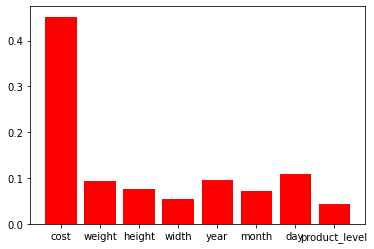

In [196]:
plt.bar(range(len(importancedt)), importancedt, color="r", align = "center")
plt.xticks(range(len(importancedt)), ['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level'])

## 4.3 Random Forest

In [197]:
steps3 = [('rescale', MinMaxScaler()),
         ('RF', RandomForestRegressor())]
model3 = Pipeline(steps3)
model3 = model3.fit(X_train, y_train)

In [198]:
parameters3 = {'RF__n_estimators':[100,200,300],
               'RF__max_depth':[3,5,10],
               'RF__min_samples_leaf':[30,100,150],
               'RF__min_samples_split':[2,3,5]}

In [199]:
scorer3 = make_scorer(mean_squared_error, greater_is_better = False)

In [200]:
model3gs = GridSearchCV(model3, parameters3, cv=5, scoring = scorer3)

In [201]:
model3gs = model3gs.fit(X_train, y_train)

In [202]:
model3gs.best_params_

{'RF__max_depth': 10,
 'RF__min_samples_leaf': 30,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 200}

In [203]:
y_train_pred3 = model3gs.predict(X_train)

In [204]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred3)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred3)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred3)))

train MAE: 9.54e+04
train MSE: 2.32e+10
train R2: 0.456


In [205]:
y_test_pred3 = model3gs.predict(X_test)

In [206]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred3)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred3)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred3)))

train MAE: 1.28e+05
train MSE: 5.20e+10
train R2: 0.397


In [208]:
importancerf = model3.steps[1][1].feature_importances_
importancerf

array([0.44364176, 0.10368345, 0.09607166, 0.06453899, 0.08137901,
       0.07316165, 0.10468172, 0.03284176])

([<matplotlib.axis.XTick at 0x18c35d3c6a0>,
 [Text(0, 0, 'cost'),
  Text(0, 0, 'weight'),
  Text(0, 0, 'height'),
  Text(0, 0, 'width'),
  Text(0, 0, 'year'),
  Text(0, 0, 'month'),
  Text(0, 0, 'day'),
  Text(0, 0, 'product_level')])

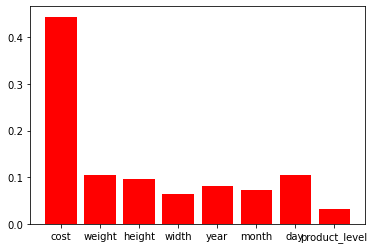

In [209]:
plt.bar(range(len(importancerf)), importancerf, color="r", align = "center")
plt.xticks(range(len(importancerf)), ['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level'])

## 4.4 Gradient Boosting Tree

In [210]:
steps4 = [('rescale', MinMaxScaler()),
         ('GBR', GradientBoostingRegressor())]
model4 = Pipeline(steps4)
model4 = model4.fit(X_train, y_train)

In [211]:
parameters4 = {'GBR__learning_rate': [0.05, 0.1], 
               'GBR__n_estimators': [100, 300, 500], 
               'GBR__max_depth': [3, 5, 10], 
               'GBR__min_samples_leaf': range(30, 150, 30), 
               'GBR__min_samples_split': [2, 3, 5]}

In [212]:
scorer4 = make_scorer(mean_squared_error, greater_is_better = False)

In [213]:
model4gs = GridSearchCV(model4, parameters4, cv=5, scoring = scorer4)

In [214]:
model4gs = model4gs.fit(X_train, y_train)

In [215]:
model4gs.best_params_

{'GBR__learning_rate': 0.1,
 'GBR__max_depth': 3,
 'GBR__min_samples_leaf': 30,
 'GBR__min_samples_split': 2,
 'GBR__n_estimators': 100}

In [216]:
y_train_pred4 = model4gs.predict(X_train)

In [217]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred4)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred4)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred4)))

train MAE: 9.28e+04
train MSE: 2.02e+10
train R2: 0.527


In [218]:
y_test_pred4 = model4gs.predict(X_test)

In [219]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred4)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred4)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred4)))

train MAE: 1.31e+05
train MSE: 5.47e+10
train R2: 0.365


In [220]:
importancegb = model4.steps[1][1].feature_importances_
importancegb

array([0.68769802, 0.06637824, 0.0310436 , 0.0157908 , 0.02607682,
       0.04859199, 0.09278854, 0.03163199])

([<matplotlib.axis.XTick at 0x18c35d6df70>,
 [Text(0, 0, 'cost'),
  Text(0, 0, 'weight'),
  Text(0, 0, 'height'),
  Text(0, 0, 'width'),
  Text(0, 0, 'year'),
  Text(0, 0, 'month'),
  Text(0, 0, 'day'),
  Text(0, 0, 'product_level')])

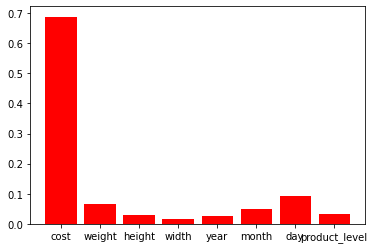

In [221]:
plt.bar(range(len(importancegb)), importancegb, color="r", align = "center")
plt.xticks(range(len(importancegb)), ['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level'])

In [222]:
X_train_gb = X_train.drop(['width'], axis=1)

In [223]:
X_test_gb = X_test.drop(['width'], axis=1)

In [225]:
model4 = model4.fit(X_train_gb, y_train)
model4gs = GridSearchCV(model4, parameters4, cv=5, scoring = scorer4)
model4gs = model4gs.fit(X_train_gb, y_train)
model4gs.best_params_

{'GBR__learning_rate': 0.05,
 'GBR__max_depth': 3,
 'GBR__min_samples_leaf': 30,
 'GBR__min_samples_split': 2,
 'GBR__n_estimators': 100}

In [226]:
y_train_pred4 = model4gs.predict(X_train_gb)

In [227]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred4)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred4)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred4)))

train MAE: 9.68e+04
train MSE: 2.24e+10
train R2: 0.475


In [228]:
y_test_pred4 = model4gs.predict(X_test_gb)

In [229]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred4)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred4)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred4)))

train MAE: 1.31e+05
train MSE: 5.50e+10
train R2: 0.363


In [230]:
importancegb = model4.steps[1][1].feature_importances_
importancegb

array([0.70879138, 0.09011766, 0.02194191, 0.02028863, 0.05291974,
       0.07600234, 0.02993833])

([<matplotlib.axis.XTick at 0x18c35f919a0>,
 [Text(0, 0, 'cost'),
  Text(0, 0, 'weight'),
  Text(0, 0, 'height'),
  Text(0, 0, 'year'),
  Text(0, 0, 'month'),
  Text(0, 0, 'day'),
  Text(0, 0, 'product_level')])

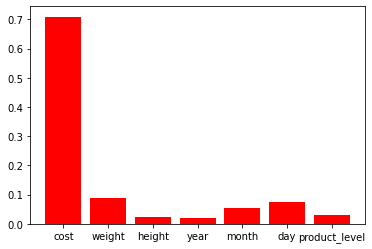

In [232]:
plt.bar(range(len(importancegb)), importancegb, color="r", align = "center")
plt.xticks(range(len(importancegb)), ['cost', 'weight', 'height', 'year', 'month', 'day',
       'product_level'])

### by dropping the feature 'width', the loss function is worse than before, so keep the 'width'

## 4.5 XgBoosting

In [ ]:
steps5 = [('rescale', MinMaxScaler()),
         ('xgb', XGBRegressor())]
model5 = Pipeline(steps5)
model5 = model5.fit(X_train, y_train)

In [ ]:
parameters5 = {'xgb__gamma': [0.0, 0.1, 0.2, 0.3], 
               'xgb__learning_rate': [0.05, 0.1], 
               'xgb__n_estimators': [100, 300, 500], 
               'xgb__max_depth': [3, 5, 10], 
               'xgb__lambda': [0.5, 1, 5], 
               'xgb__min_child_weight': [3, 5, 7]}

In [ ]:
model5gs = GridSearchCV(model5, parameters5, cv=5, scoring = scorer)

In [ ]:
model5gs = model5gs.fit(X_train, y_train)

In [ ]:
model5gs.best_params_

In [ ]:
y_train_pred5 = model5gs.predict(X_train)

In [ ]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred5)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred5)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred5)))

In [ ]:
y_test_pred5 = model5gs.predict(X_test)

In [ ]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred5)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred5)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred5)))

In [ ]:
importancexg = model5.steps[1][1].feature_importances_
importancexg

In [ ]:
plt.bar(range(len(importancexg)), importancexg, color="r", align = "center")
plt.xticks(range(len(importancexg)), ['cost', 'weight', 'height', 'width', 'year', 'month', 'day',
       'product_level'])